### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting
from skopt.space import Categorical, Integer, Real 

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'mean_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_hparams = os.path.join(path, 'mean_hparams')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_hparams)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory already exsist!
Directory created!


In [4]:
for i in ['RandomForest_AD_vs_CN']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass
    
    path_hparams2 = os.path.join(path_hparams, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_hparams2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory created!
Directory created!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [7]:
def impute_mean(group):
    return group.fillna(group.mean())

nan_cols = train.isna().sum()[train.isna().sum()>0].index.tolist()

for i in nan_cols:
    train[i] = train[i].transform(impute_mean)
    
nan_cols = test.isna().sum()[test.isna().sum()>0].index.tolist()

for i in nan_cols:
    test[i] = test[i].fillna(test[i].mean())

### Search for hyperparams

In [8]:
final_cols = ['diagnosis', 'year_birth', 'sex', 'years_education',
              'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
              'mmse_vs', 'moca_vs','ace_vs', 'functionality', 'marital_status',
              'n_children', 'household_members', 'household_income', 'Job_status']

final_cols2 = ['diagnosis', 'ifs_total_score', 'mini_sea_total', 'npi_total',
               'npi_total_caregiver', 'mmse_vs', 'moca_vs','ace_vs', 'functionality' ]

final_cols3 = ['diagnosis', 'year_birth', 'sex', 'years_education','ifs_total_score',
               'mini_sea_total', 'npi_total', 'npi_total_caregiver', 'cognition',
               'functionality', 'marital_status', 'n_children', 'household_members',
               'household_income', 'Job_status' ]


In [9]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and CN
data = train.query("diagnosis != 'FTD'")
data['diagnosis'] = data['diagnosis'].replace({'AD':1, 'CN':0})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'FTD'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':1, 'CN':0})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

# ### Split into FTD and CN
# data_ftd = train.query("diagnosis != 'AD'")
# data_ftd['diagnosis'] = data_ftd['diagnosis'].replace({'FTD':1, 'CN':0})
# data_ftd = data_ftd.sample(data_ftd.shape[0], ignore_index=True)
# unseen_ftd = test.query("diagnosis != 'AD'")
# unseen_ftd['diagnosis'] = unseen_ftd['diagnosis'].replace({'FTD':1, 'CN':0})
# unseen_ftd = unseen_ftd.sample(unseen_ftd.shape[0], ignore_index=True)

In [10]:
## Random Forest Hparams
rf_grid= {"n_estimators": Integer(low=25, high=500),
    "criterion": Categorical(['gini', 'entropy']),
    "max_depth": Integer(low=1, high=10),
    "min_samples_split": Real(low=0.01, high=0.99),
    "min_samples_leaf": Real(low=0.01, high=0.5),
    "max_features":Integer(low=1, high=10)}

rf_param = { "class_weight":"balanced", "verbose":0, "n_jobs":-1}


In [11]:
data1 = data[final_cols].copy()

best, raw = bhs.hparams_search(data1, 'diagnosis', RandomForestClassifier(),
                               rf_grid, rf_param,
                               scaler='MM', test_size= .2,
                               cv=StratifiedKFold(5, shuffle=True), n_iter=100)

raw.to_csv(path_hparams2 + "/RF_hparams.csv")
print('All Done!')
print(best)

Best score: 0.9756104355617845
	
Test score: 0.9874955845990816
	
Execution time: 3.675842233498891 minutes
All Done!
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 500}


In [12]:
##########################################
################## Only test cols
data2 = data[final_cols2].copy()

## Random Forest Hparams

rf_grid2= {"n_estimators": Integer(low=25, high=500),
    "criterion": Categorical(['gini', 'entropy']),
    "max_depth": Integer(low=1, high=6),
    "min_samples_split": Real(low=0.01, high=0.99),
    "min_samples_leaf": Real(low=0.01, high=0.5),
    "max_features":Integer(low=1, high=6)}


best, raw = bhs.hparams_search(data2, 'diagnosis', RandomForestClassifier(), rf_grid2, rf_param, scaler='MM', test_size= .2, cv=StratifiedKFold(5, shuffle=True), n_iter=100)
raw.to_csv(path_hparams2 + "/RF_hparams_fcols2.csv")
print('All Done!')
# Save RF hparams
print(best)

Best score: 0.9805156033705348
	
Test score: 0.9712115860120099
	
Execution time: 3.2342289408047993 minutes
All Done!
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 1, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 25}


In [13]:
###########################################
################## with Cognition col
data3 = data[final_cols3].copy()

## Random Forest Hparams

rf_grid3= {"n_estimators": Integer(low=25, high=500),
    "criterion": Categorical(['gini', 'entropy']),
    "max_depth": Integer(low=1, high=6),
    "min_samples_split": Real(low=0.01, high=0.99),
    "min_samples_leaf": Real(low=0.01, high=0.5),
    "max_features":Integer(low=1, high=6)}

rf_param = { "class_weight":"balanced", "verbose":0, "n_jobs":-1}

best, raw = bhs.hparams_search(data3, 'diagnosis', RandomForestClassifier(), rf_grid3, rf_param, scaler='MM', test_size= .2, cv=StratifiedKFold(5, shuffle=True), n_iter=100)
raw.to_csv(path_hparams2 + "/RF_hparams_fcols3.csv")
print('All Done!')
print(best)


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Best score: 0.9785926810915754
	
Test score: 0.9663723066054399
	
Execution time: 3.044042925039927 minutes
All Done!
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 500}


### Load Hyperparams


In [14]:
### Load Hyperparams
# hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-09-23/mean_hparams/"
# xgb_hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-11-07/mean_hparams/" # Desktop

#fcols 1
rf_hp1 = pd.read_csv(path_hparams2 + "/RF_hparams.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp1= rf_hp1[rf_hp1['mean_test_score'] < rf_hp1['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

#fcols 2
rf_hp2 = pd.read_csv(path_hparams2 + "/RF_hparams_fcols2.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp2= rf_hp2[rf_hp2['mean_test_score'] < rf_hp2['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

#fcols 3
rf_hp3 = pd.read_csv(path_hparams2 + "/RF_hparams_fcols3.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp3= rf_hp3[rf_hp3['mean_test_score'] < rf_hp3['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)



In [15]:
rf_row = 0
rf_hp1.iloc[rf_row,:]

param_criterion                                                      entropy
param_max_depth                                                           10
param_max_features                                                         1
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                       500
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                      0.97561
mean_train_score                                                    0.986442
Name: 0, dtype: object

In [16]:
rf_hp2.iloc[rf_row,:]

param_criterion                                                      entropy
param_max_depth                                                            6
param_max_features                                                         1
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                        25
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                     0.980516
mean_train_score                                                    0.986286
Name: 0, dtype: object

In [17]:
rf_hp3.iloc[rf_row,:]

param_criterion                                                      entropy
param_max_depth                                                            6
param_max_features                                                         4
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                       500
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                     0.978593
mean_train_score                                                    0.991479
Name: 0, dtype: object

In [18]:
## Models Hparams
# RF
rf_params1= {"n_estimators": rf_hp1.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp1.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp1.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp1.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp1.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp1.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

rf_params2= {"n_estimators": rf_hp2.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp2.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp2.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp2.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp2.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp2.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

rf_params3= {"n_estimators": rf_hp3.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp3.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp3.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp3.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp3.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp3.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

In [19]:
n_iter = 5000

### Base model: Logistic Regression

In [20]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data1, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating: 100%|██████████████████| 5000/5000 [03:24<00:00, 24.43it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:3.4113274971644083 minutes
empirical p-value: 0.0



invalid value encountered in sqrt
invalid value encountered in sqrt


In [21]:
lr_res.mean()

Accuracy         0.933619
ROC_AUC          0.973905
Precision        0.958601
Recall           0.931746
Sensitivity      0.931746
Specificity      0.936556
F1               0.944836
Efron_pR2        0.743258
mcfadden_pR2    -6.140001
mcfadden_apR2   -6.229840
dtype: float64

In [22]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.0069,0.004419,0.005522,0.00699,0.00699,0.006757,0.006328,0.012108,NaN,NaN


In [23]:
lr_res_r

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,Job_status,0.857548,0.165780,10.213786,2.238224,1.698360e-06,8.297714e-05
1,ace_vs,-6.072158,0.158678,-18.721887,2.284236,0.000000e+00,0.000000e+00
2,functionality,1.565672,0.179541,14.416435,2.247680,0.000000e+00,0.000000e+00
3,household_income,0.219668,0.180266,1.605431,1.353571,3.291156e-01,3.019164e-01
4,household_members,0.291189,0.163704,1.134022,0.685864,5.826770e-01,1.369690e-01
5,ifs_total_score,-1.982850,0.164047,-11.609192,1.893703,0.000000e+00,0.000000e+00
6,marital_status,-0.122167,0.155284,-1.387750,1.765002,3.466604e-01,3.276114e-01
7,mini_sea_total,-0.772733,0.166984,-3.143000,1.132716,2.070096e-02,3.244259e-02
8,mmse_vs,-3.121300,0.194621,-7.704415,1.177163,9.210418e-09,1.369006e-07
9,moca_vs,-5.391296,0.176731,-19.856416,2.637239,0.000000e+00,0.000000e+00


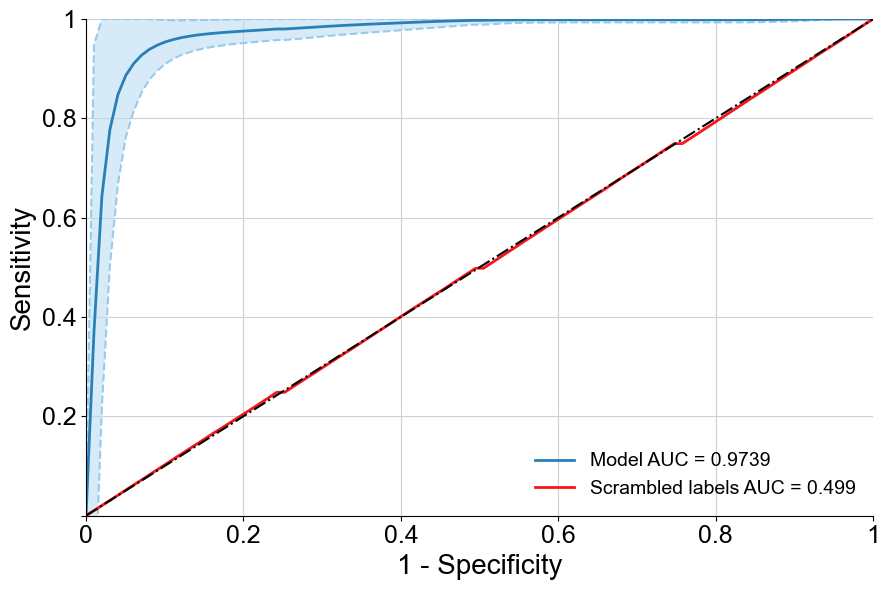

In [24]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [25]:
rf_fimp = bc.permutation_FIMP(data1, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [26]:
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

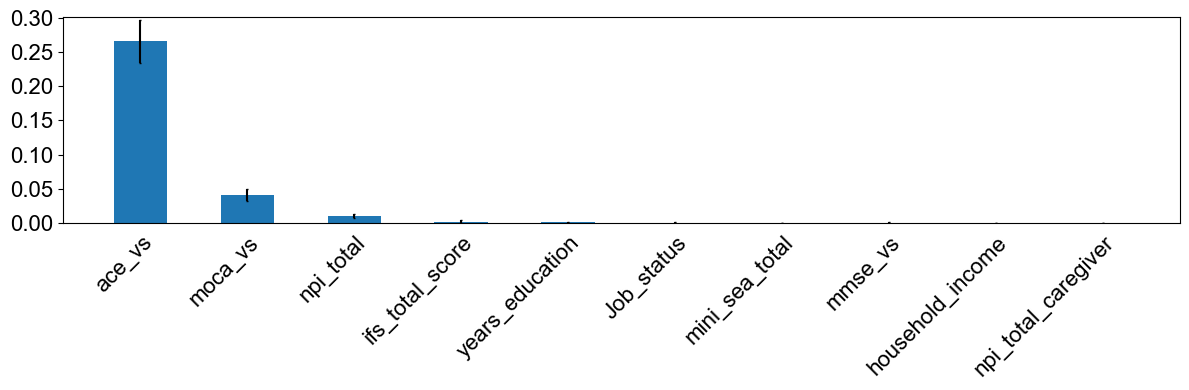

In [27]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

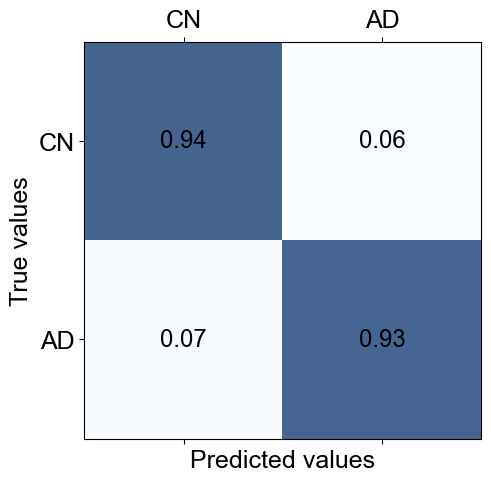

In [28]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['CN', 'AD'],fname=None)

#### unseen data

In [29]:
X_train, y_train = data1.drop('diagnosis', axis=1), data1[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data1.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [30]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [31]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [32]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [33]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.9569
Accuracy: 0.9632
Recall: 0.9878
F1: 0.9701
Precision:0.9529


In [34]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.9569
Bootstrping test ROC score: 	0.9739


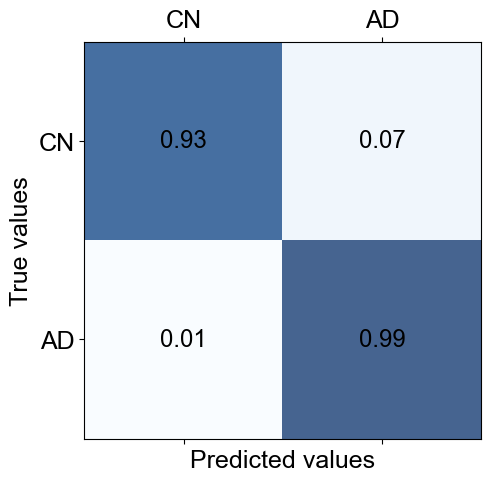

In [35]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'AD'])

### RF Model

#### Bootstrap 1

In [36]:
Model_res1, CI_df1, Model_res_r1, ROC_AUC1, CM1, ROC_chance1, empirical_p_value1 = bc.Bootstrap_tree_classifier(
    data1, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params1, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=1, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=500, n_jobs=-1)


Iterating: 100%|████████████████| 5000/5000 [1:22:37<00:00,  1.01it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:82.6213212331136 minutes
empirical p-value: 0.0


In [37]:
path_res2


'/home/marcelo/GitRepos/Tesis/pred_results/2024-01-09/mean_res/RandomForest_AD_vs_CN'

In [38]:
Model_res1.to_csv(path_res2+ "/Model_res1.csv", index=False)
Model_res1.mean()

Accuracy       0.936918
ROC_AUC        0.977811
Precision      0.961521
Recall         0.934282
Sensitivity    0.934282
Specificity    0.941053
F1             0.947560
Efron_pR2      0.749931
dtype: float64

In [39]:
print("%.4f" % Model_res1['ROC_AUC'].mean())

0.9778


In [40]:
CI_df1.to_csv(path_res2+ "/CI_df1.csv", index=False)
CI_df1

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.006739,0.004083,0.005332,0.006868,0.006868,0.006528,0.006179,0.012004


In [41]:
Model_res_r1.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/Model_res_r1.csv", index=False)
Model_res_r1.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
1,ace_vs,0.235610,0.013675
9,moca_vs,0.217231,0.012938
8,mmse_vs,0.213564,0.013068
5,ifs_total_score,0.052745,0.004431
2,functionality,0.046984,0.003753
14,year_birth,0.040820,0.003399
11,npi_total,0.037825,0.003267
15,years_education,0.035333,0.003155
7,mini_sea_total,0.025538,0.002453
12,npi_total_caregiver,0.021537,0.002015


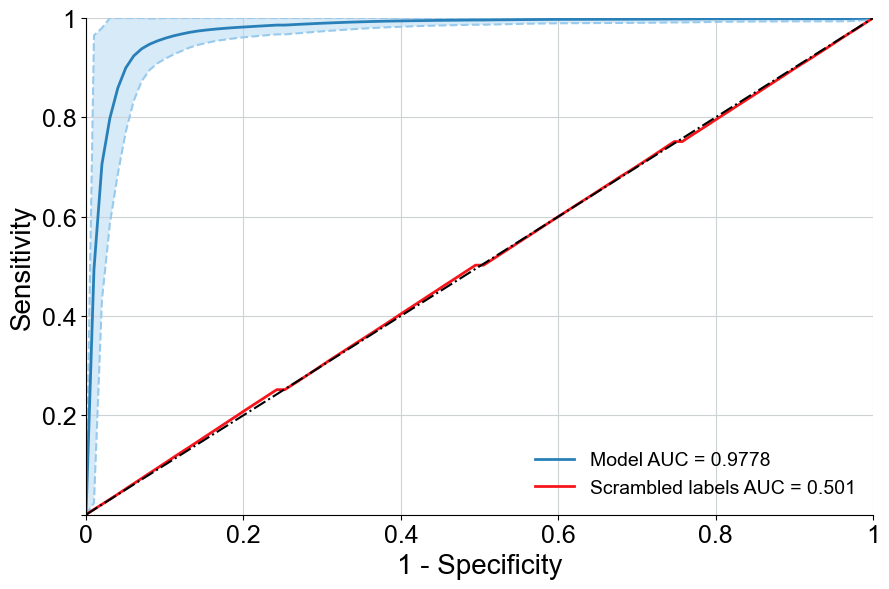

In [42]:
ml_plotting.plot_custom_roc_curve(ROC_AUC1, ROC_chance1, fname=path_res2+ "/ROC_AUC_curve1.png")

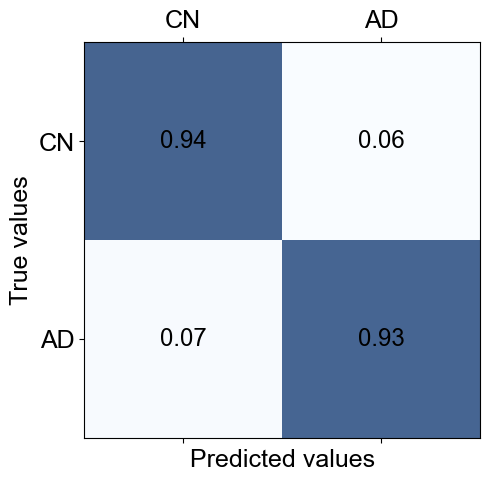

In [43]:
ml_plotting.plot_boostrap_CM(CM1, labels=['CN', 'AD'],fname=path_res2+ "/CM1.png")

##### Permutation Feature importance

In [44]:
rf_fimp1 = bc.permutation_FIMP(data1, 'diagnosis', RandomForestClassifier(), params=rf_params1, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [45]:
rf_fimp1.sort_values('mean', ascending=False).to_csv(path_res2+ "/rf_PFI1.csv")
top_10p1 = rf_fimp1.sort_values('mean', ascending=False).head(10)

In [46]:
top_10p1

,predictor,mean,std
9,ace_vs,0.024225,0.007018
7,mmse_vs,0.011693,0.006243
8,moca_vs,0.009919,0.005775
5,npi_total,0.002739,0.001451
10,functionality,0.002119,0.002692
6,npi_total_caregiver,0.001391,0.001270
4,mini_sea_total,0.001390,0.002018
3,ifs_total_score,0.000887,0.002743
1,sex,0.000792,0.000557
0,year_birth,0.000258,0.001451


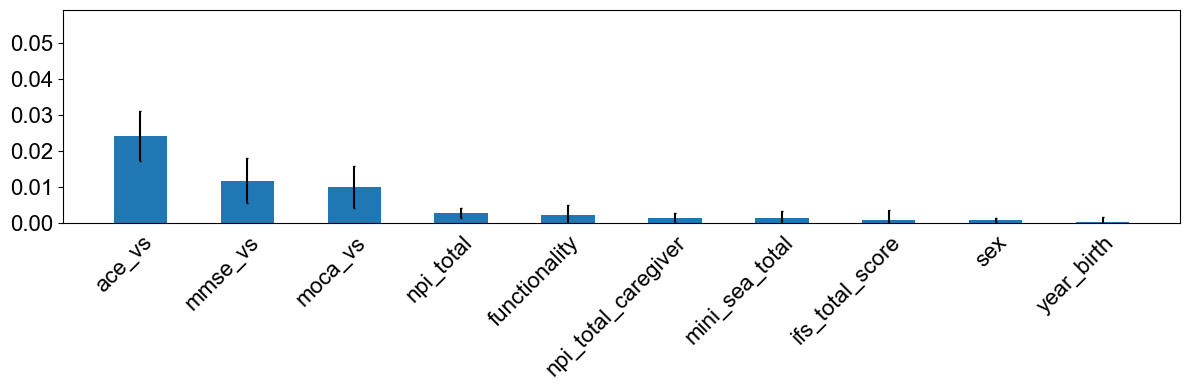

In [47]:
ml_plotting.plot_permutation_FIMP(top_10p1, names='predictor', importances_col='mean', std_col='std')

In [48]:
Model_res_r1.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
1,ace_vs,0.235610,0.013675
9,moca_vs,0.217231,0.012938
8,mmse_vs,0.213564,0.013068
5,ifs_total_score,0.052745,0.004431
2,functionality,0.046984,0.003753


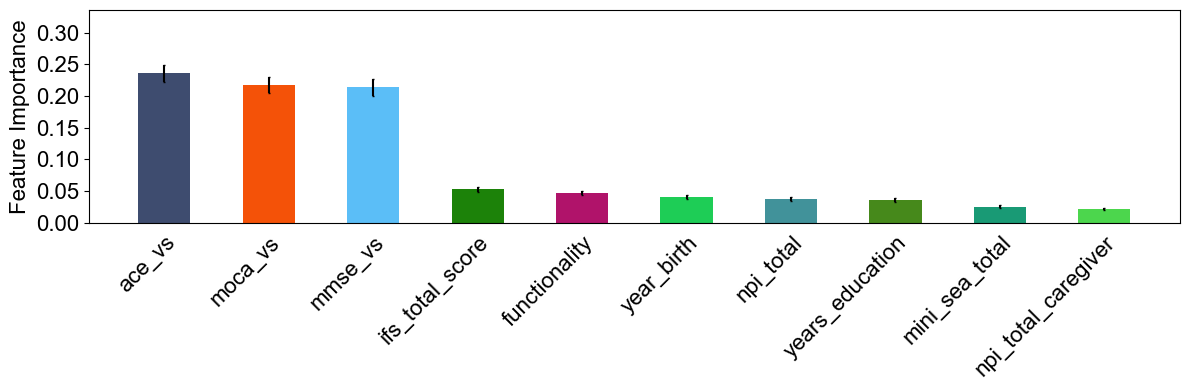

In [49]:
top_10_1 = Model_res_r1.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10_1, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [50]:
X_train, y_train = data1.drop('diagnosis', axis=1), data1[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data1.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [51]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [52]:
# predict & scores
rfc = RandomForestClassifier(**rf_params1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [53]:
unseen_df1 = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df1.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df1.to_csv(path_res+ "/unseen1.csv")

In [54]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.9074
Accuracy: 0.9265
Recall: 1.0
F1: 0.9425
Precision:0.8913


In [55]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res1['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.9074
Bootstrping test ROC score: 	0.9778


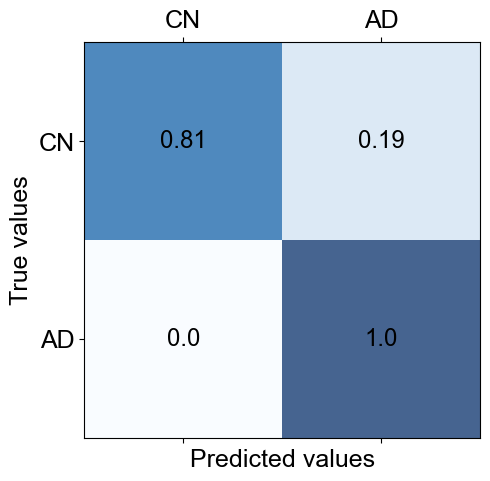

In [56]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'AD'],fname=path_res2+ "/CM_unseen1.png")

#### Shapley

In [57]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

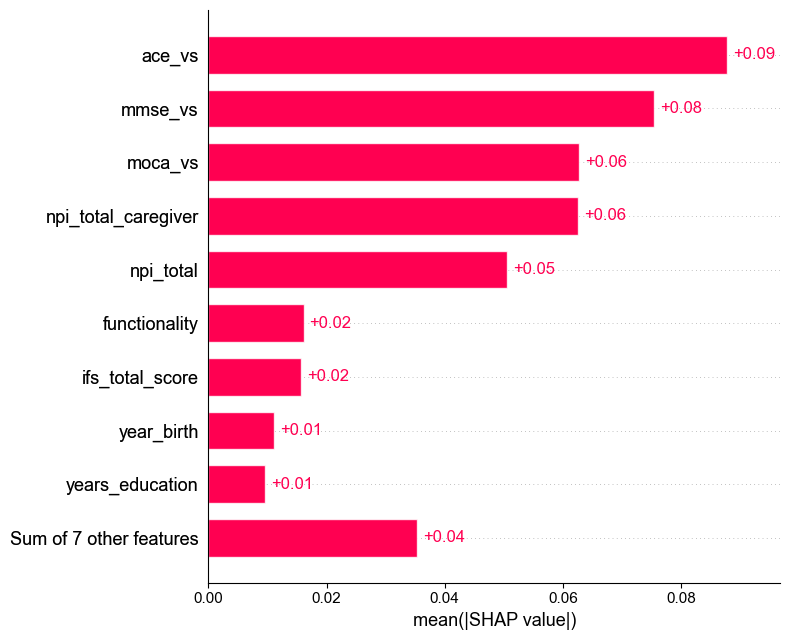

In [58]:
shap.plots.bar(shap_values[:,:,1])

#### Bootstrap 2

In [59]:
Model_res2, CI_df2, Model_res_r2, ROC_AUC2, CM2, ROC_chance2, empirical_p_value2 = bc.Bootstrap_tree_classifier(
    data2, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params2, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, max_features=1, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=25, n_jobs=-1)


Iterating: 100%|██████████████████| 5000/5000 [05:56<00:00, 14.03it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:5.939720555146535 minutes
empirical p-value: 0.0


In [60]:
Model_res2.to_csv(path_res2+ "/Model_res2.csv", index=False)
Model_res2.mean()

Accuracy       0.939305
ROC_AUC        0.977429
Precision      0.965065
Recall         0.934638
Sensitivity    0.934638
Specificity    0.946625
F1             0.949454
Efron_pR2      0.782980
dtype: float64

In [61]:
print("%.4f" % Model_res2['ROC_AUC'].mean())

0.9774


In [62]:
CI_df2.to_csv(path_res2+ "/CI_df2.csv", index=False)
CI_df2

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.006618,0.004117,0.00509,0.006851,0.006851,0.006231,0.006072,0.011426


In [63]:
Model_res_r2.sort_values('Importance_mean', ascending=False).to_csv(path_res2+ "/Model_res_r2.csv", index=False)
Model_res_r2.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
0,ace_vs,0.277691,0.069530
5,moca_vs,0.251509,0.066618
4,mmse_vs,0.246820,0.065594
2,ifs_total_score,0.062563,0.019163
1,functionality,0.057902,0.016836
6,npi_total,0.046248,0.013165
3,mini_sea_total,0.034245,0.010607
7,npi_total_caregiver,0.023023,0.007731


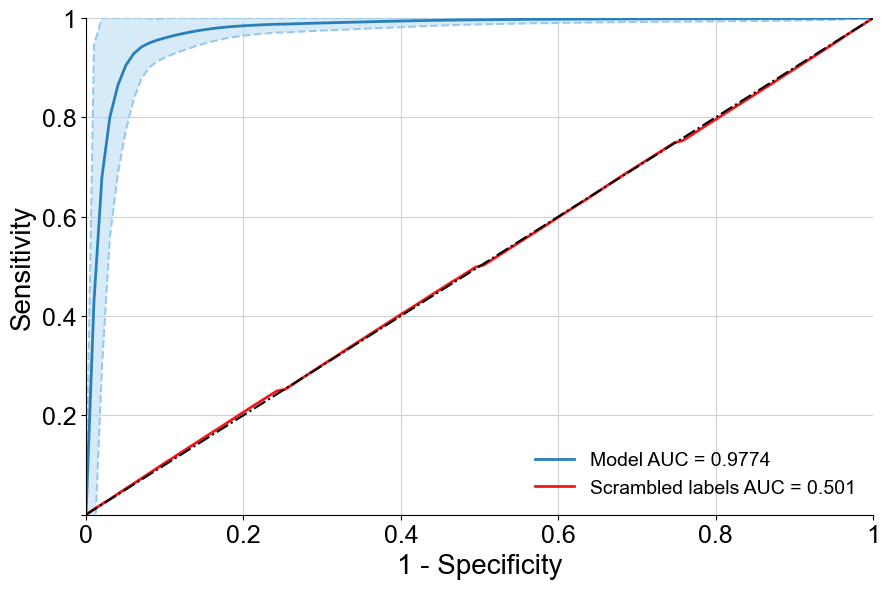

In [64]:
ml_plotting.plot_custom_roc_curve(ROC_AUC2, ROC_chance2, fname=path_res2+ "/ROC_AUC_curve2.png")

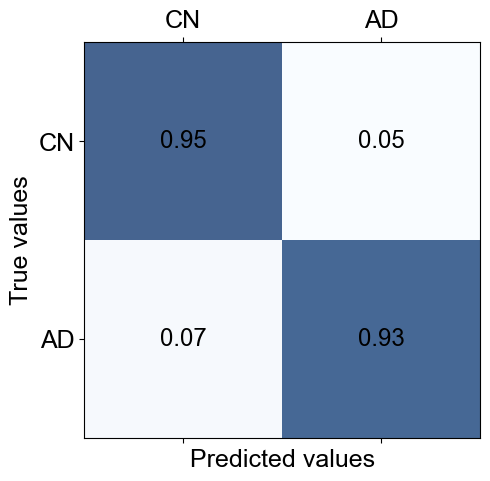

In [65]:
ml_plotting.plot_boostrap_CM(CM2, labels=['CN', 'AD'],fname=path_res2+ "/CM2.png")

##### Permutation Feature importance

In [66]:
rf_fimp = bc.permutation_FIMP(data2, 'diagnosis', RandomForestClassifier(),
                              params=rf_params2, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [67]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res2+ "/rf_PFI2.csv")
top_10p2 = rf_fimp.sort_values('mean', ascending=False).head(10)

In [68]:
top_10p2

,predictor,mean,std
6,ace_vs,0.033668,0.009544
4,mmse_vs,0.008059,0.005455
2,npi_total,0.006074,0.003235
5,moca_vs,0.005780,0.004639
0,ifs_total_score,0.002869,0.003679
1,mini_sea_total,0.001890,0.002422
3,npi_total_caregiver,0.001682,0.001667
7,functionality,0.001169,0.002587


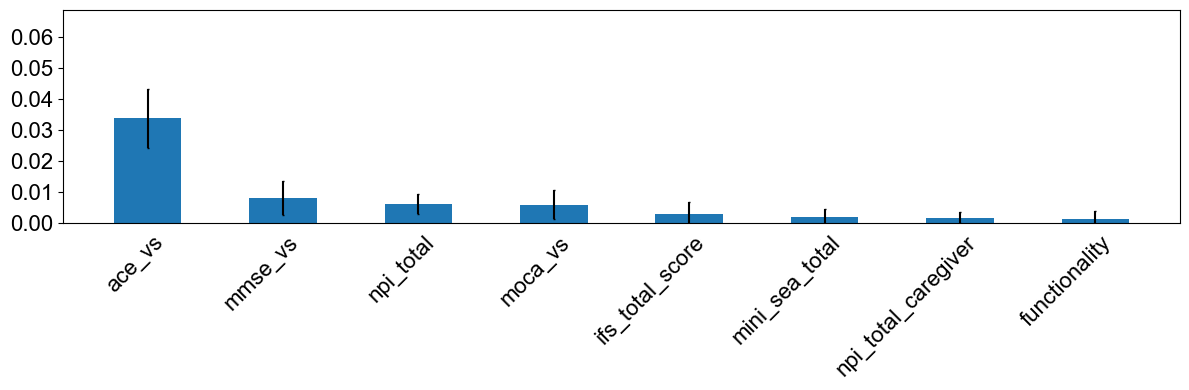

In [69]:
ml_plotting.plot_permutation_FIMP(top_10p2, names='predictor', importances_col='mean', std_col='std')

In [70]:
Model_res_r2.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
0,ace_vs,0.277691,0.069530
5,moca_vs,0.251509,0.066618
4,mmse_vs,0.246820,0.065594
2,ifs_total_score,0.062563,0.019163
1,functionality,0.057902,0.016836


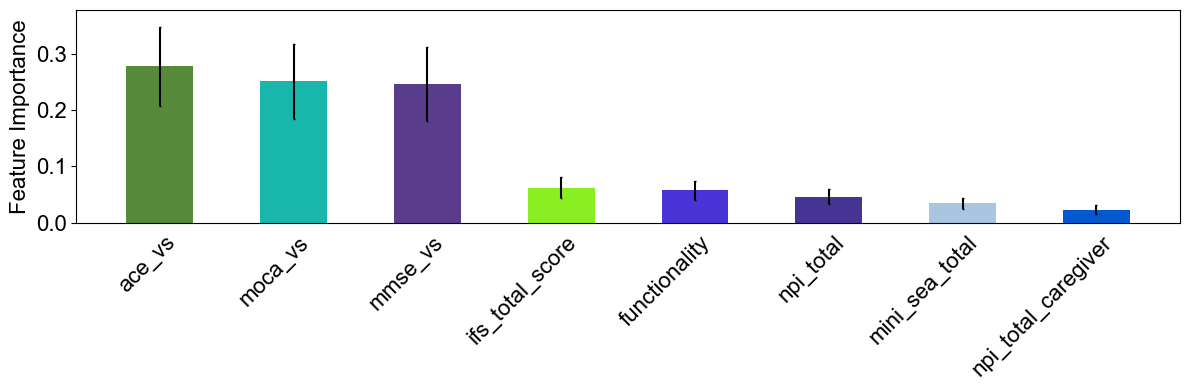

In [71]:
top_10_2 = Model_res_r2.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10_2, 'variables','Importance_mean', 'Importance_std')

##### unseen data


In [72]:
X_train, y_train = data2.drop('diagnosis', axis=1), data2[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data2.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [73]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [74]:
# predict & scores
rfc = RandomForestClassifier(**rf_params2)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [75]:
unseen_df2 = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df2.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df2.to_csv(path_res2+ "/unseen2.csv")

In [76]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.8241
Accuracy: 0.8603
Recall: 1.0
F1: 0.8962
Precision:0.8119


In [77]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res2['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.8241
Bootstrping test ROC score: 	0.9774


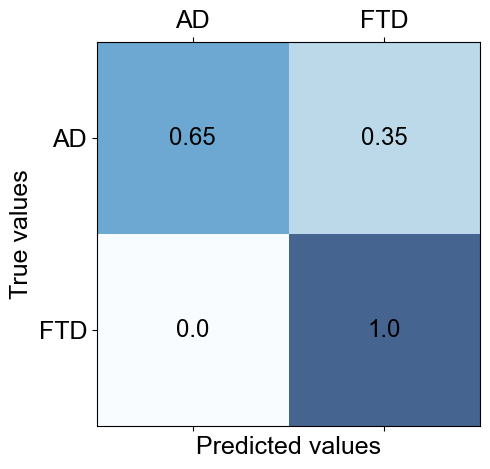

In [78]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'],fname=path_res2+ "/CM_unseen2.png")

In [79]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

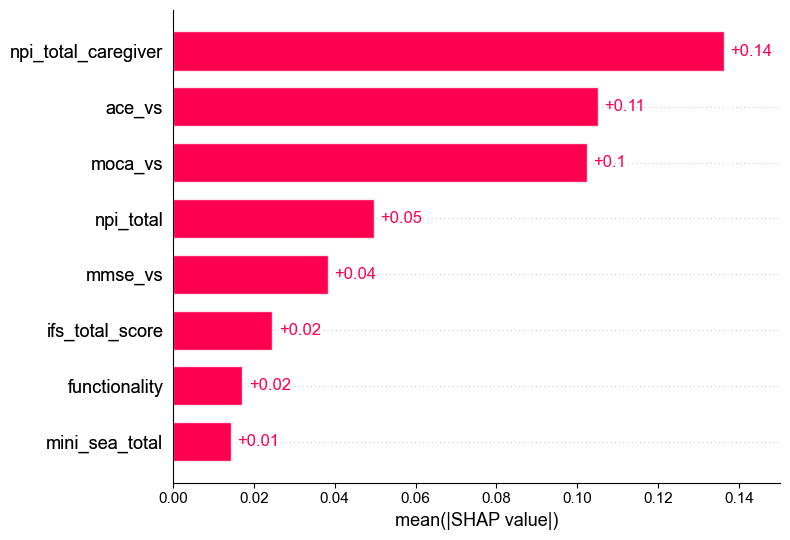

In [80]:
shap.plots.bar(shap_values[:,:,1])

#### Bootstrap 3

In [81]:
Model_res3, CI_df3, Model_res_r3, ROC_AUC3, CM3, ROC_chance3, empirical_p_value3 = bc.Bootstrap_tree_classifier(
    data3, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params3, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, max_features=4, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=500, n_jobs=-1)


Iterating: 100%|████████████████| 5000/5000 [1:21:32<00:00,  1.02it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:81.54647248983383 minutes
empirical p-value: 0.0


In [82]:
Model_res3.to_csv(path_res2+ "/Model_res3.csv", index=False)
Model_res3.mean()

Accuracy       0.932908
ROC_AUC        0.977035
Precision      0.955607
Recall         0.933795
Sensitivity    0.933795
Specificity    0.931518
F1             0.944395
Efron_pR2      0.776643
dtype: float64

In [83]:
print("%.4f" % Model_res3['ROC_AUC'].mean())

0.9770


In [84]:
CI_df3.to_csv(path_res2+ "/CI_df3.csv", index=False)
CI_df3

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.006935,0.004152,0.005709,0.006892,0.006892,0.007001,0.006352,0.011545


In [85]:
Model_res_r3.sort_values('Importance_mean', ascending=False).to_csv(path_res2+ "/Model_res_r3.csv", index=False)
Model_res_r3.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
1,cognition,0.656825,0.011946
5,ifs_total_score,0.083765,0.006283
2,functionality,0.071882,0.006662
9,npi_total,0.052764,0.005263
12,year_birth,0.037808,0.004889
13,years_education,0.032951,0.004526
7,mini_sea_total,0.019550,0.002983
8,n_children,0.009520,0.001674
10,npi_total_caregiver,0.008805,0.001515
0,Job_status,0.008207,0.001410


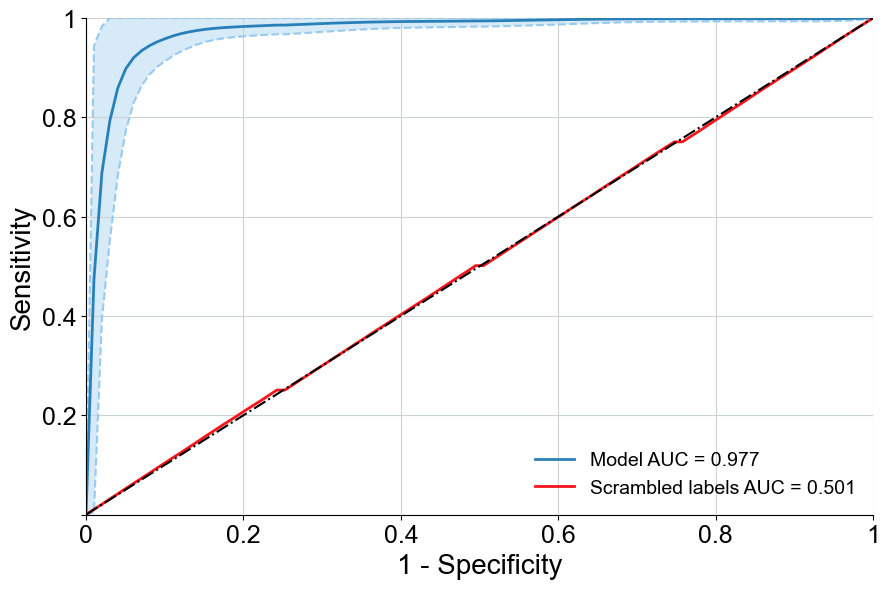

In [86]:
ml_plotting.plot_custom_roc_curve(ROC_AUC3, ROC_chance3, fname=path_res2+ "/ROC_AUC_curve3.png")

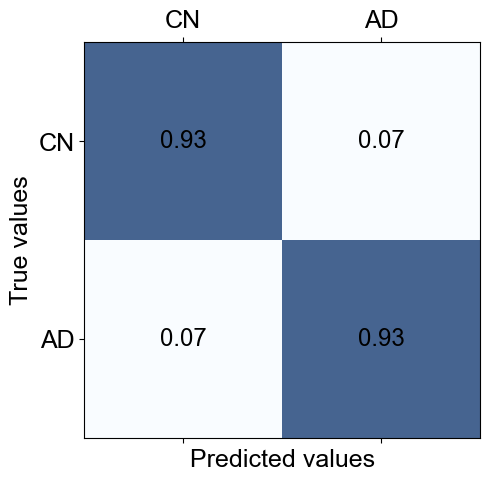

In [87]:
ml_plotting.plot_boostrap_CM(CM3, labels=['CN', 'AD'],fname=path_res2+ "/CM3.png")

##### Permutation Feature importance

In [88]:
rf_fimp3 = bc.permutation_FIMP(data3, 'diagnosis', RandomForestClassifier(), params=rf_params3, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [89]:
rf_fimp3.sort_values('mean', ascending=False).to_csv(path_res2+ "/rf_PFI3.csv")
top_10p3 = rf_fimp3.sort_values('mean', ascending=False).head(10)

In [90]:
top_10p3

,predictor,mean,std
7,cognition,0.289900,0.031264
5,npi_total,0.007447,0.003332
8,functionality,0.002274,0.004104
3,ifs_total_score,0.001770,0.004393
2,years_education,0.001600,0.002469
0,year_birth,0.001248,0.003094
6,npi_total_caregiver,0.000528,0.001150
4,mini_sea_total,0.000510,0.002356
11,household_members,-0.000043,0.000385
1,sex,-0.000174,0.000262


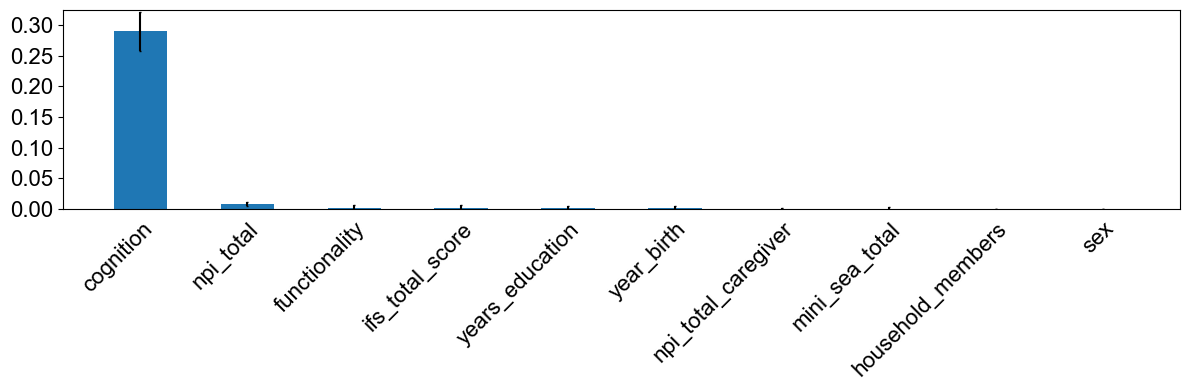

In [91]:
ml_plotting.plot_permutation_FIMP(top_10p3, names='predictor', importances_col='mean', std_col='std')

In [92]:
Model_res_r3.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
1,cognition,0.656825,0.011946
5,ifs_total_score,0.083765,0.006283
2,functionality,0.071882,0.006662
9,npi_total,0.052764,0.005263
12,year_birth,0.037808,0.004889


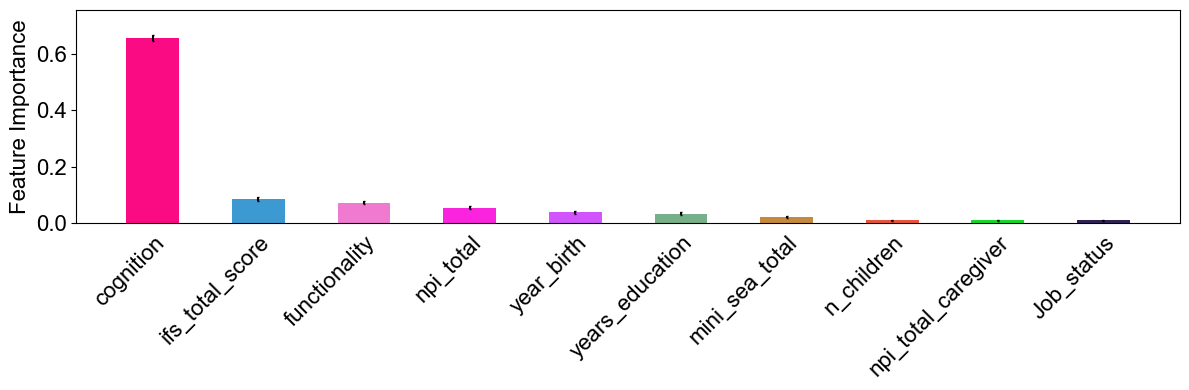

In [93]:
top_10_3 = Model_res_r3.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10_3, 'variables','Importance_mean', 'Importance_std')

##### unseen data


In [94]:
X_train, y_train = data3.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data3.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [95]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [96]:
# predict & scores
rfc = RandomForestClassifier(**rf_params3)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [97]:
unseen_df3 = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df3.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df3.to_csv(path_res2+ "/unseen3.csv")

In [98]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.9444
Accuracy: 0.9559
Recall: 1.0
F1: 0.9647
Precision:0.9318


In [99]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res3['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.9444
Bootstrping test ROC score: 	0.9770


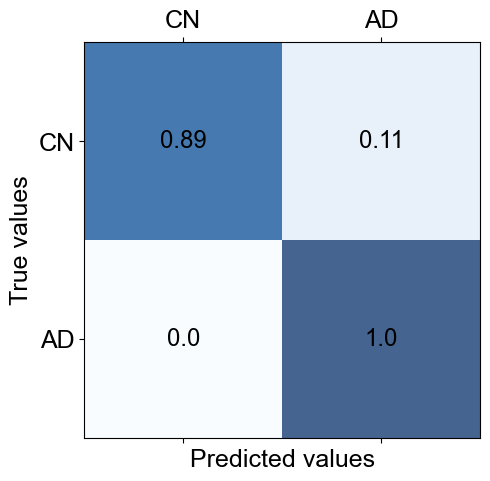

In [100]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'AD'],fname=path_res2+ "/CM_unseen3.png")

In [101]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)


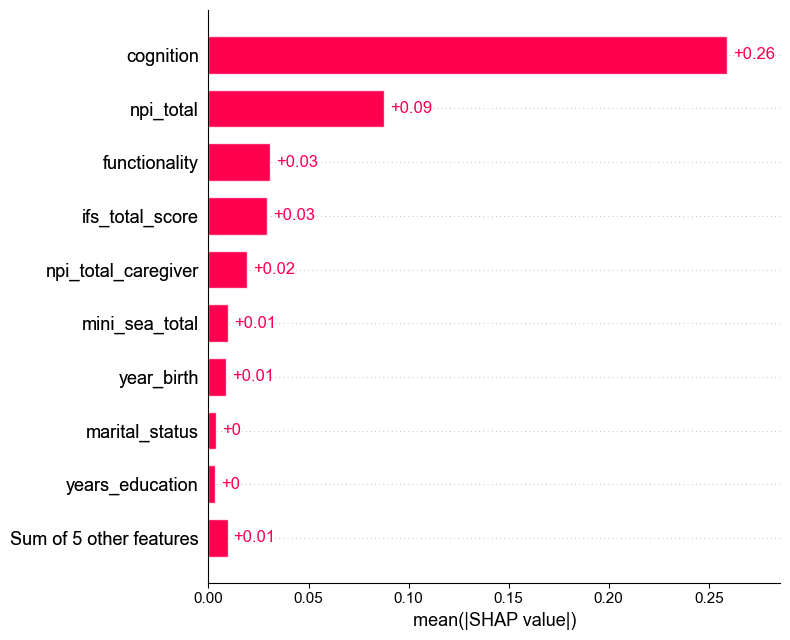

In [102]:
shap.plots.bar(shap_values[:,:,1])

### Sequential feature selector

#### RF

In [103]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [104]:
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits)

In [105]:
rf_params3['max_features'] =1

In [106]:
sfs_rfc = SFS(RandomForestClassifier(**rf_params3), 
           k_features='best', 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [107]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    3.6s finished
Features: 1/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    3.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    3.9s finished
Features: 2/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    3.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.5s finished
Features: 3/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    3.2s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.3s finished
Features: 4/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 

In [108]:
sfs_rf = pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

In [109]:
sfs_rf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(7,)","[0.8943488943488943, 0.9262899262899262, 0.916...",0.912298,"(cognition,)",0.030012,0.013337,0.009431
2,"(7, 8)","[0.9066339066339066, 0.9336609336609336, 0.926...",0.922134,"(cognition, functionality)",0.025622,0.011386,0.008051
3,"(4, 7, 8)","[0.914004914004914, 0.9459459459459459, 0.9408...",0.933613,"(mini_sea_total, cognition, functionality)",0.031544,0.014018,0.009912
4,"(4, 5, 7, 8)","[0.9287469287469288, 0.9484029484029484, 0.931...",0.936061,"(mini_sea_total, npi_total, cognition, functio...",0.01975,0.008777,0.006206
5,"(4, 5, 6, 7, 8)","[0.9312039312039312, 0.9484029484029484, 0.926...",0.935238,"(mini_sea_total, npi_total, npi_total_caregive...",0.021464,0.009538,0.006745
6,"(3, 4, 5, 6, 7, 8)","[0.9312039312039312, 0.9484029484029484, 0.928...",0.936059,"(ifs_total_score, mini_sea_total, npi_total, n...",0.01979,0.008794,0.006218
7,"(3, 4, 5, 6, 7, 8, 11)","[0.9336609336609336, 0.9533169533169533, 0.926...",0.937695,"(ifs_total_score, mini_sea_total, npi_total, n...",0.025808,0.011468,0.008109
8,"(3, 4, 5, 6, 7, 8, 11, 12)","[0.9312039312039312, 0.9533169533169533, 0.926...",0.936876,"(ifs_total_score, mini_sea_total, npi_total, n...",0.026576,0.01181,0.008351
9,"(3, 4, 5, 6, 7, 8, 9, 11, 12)","[0.9287469287469288, 0.9508599508599509, 0.928...",0.936059,"(ifs_total_score, mini_sea_total, npi_total, n...",0.023551,0.010466,0.0074
10,"(3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","[0.9312039312039312, 0.9508599508599509, 0.926...",0.936057,"(ifs_total_score, mini_sea_total, npi_total, n...",0.024015,0.010672,0.007546


In [110]:
sfs_rf.loc[[5],:]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
5,"(4, 5, 6, 7, 8)","[0.9312039312039312, 0.9484029484029484, 0.926...",0.935238,"(mini_sea_total, npi_total, npi_total_caregive...",0.021464,0.009538,0.006745


In [111]:
# 5, 13
sfs_rf_features = list(sfs_rf.loc[5, 'feature_names'])

In [112]:
sfs_rf_features

['mini_sea_total',
 'npi_total',
 'npi_total_caregiver',
 'cognition',
 'functionality']

In [113]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

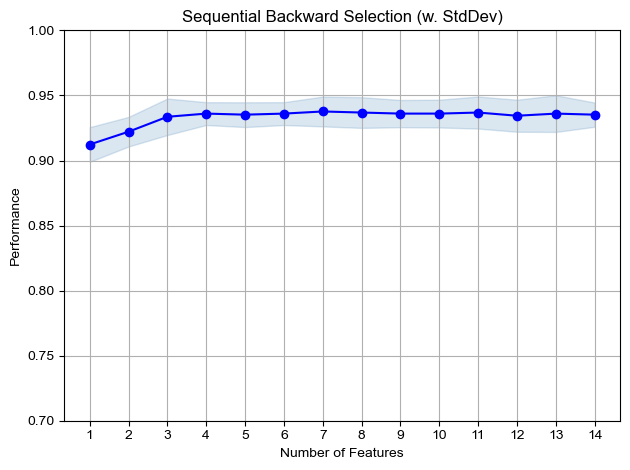

In [114]:
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0.7, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

### Shapley

In [115]:
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

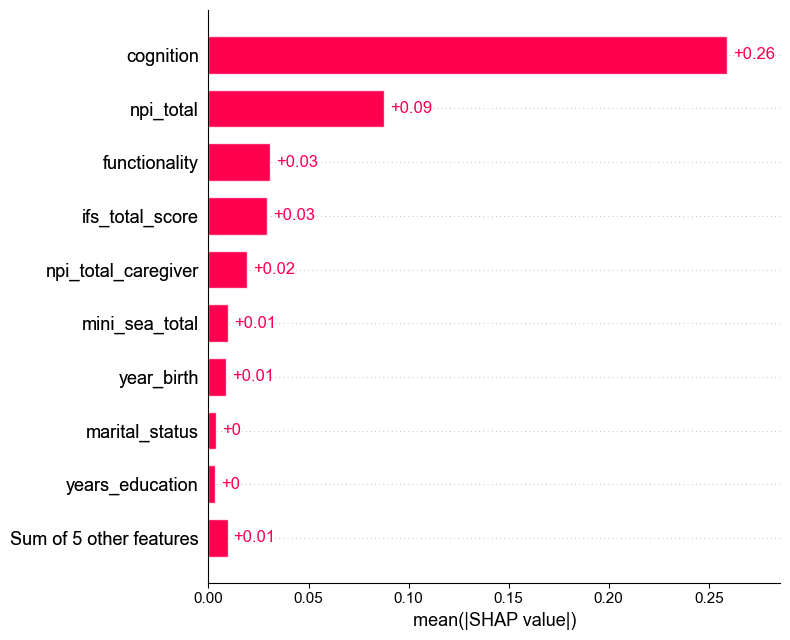

In [116]:
shap.plots.bar(shap_values[:,:,1])